In [1]:
import joblib
import pandas as pd
df = pd.read_csv('../data/processed_bank_transaction_data.csv')

In [2]:
df.columns

Index(['AccountID', 'TransactionAmount', 'TransactionType', 'Location',
       'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerAge',
       'CustomerOccupation', 'TransactionDuration', 'LoginAttempts',
       'AccountBalance', 'amount_to_balance_ratio', 'avg_txn_amount_account',
       'txn_amount_account', 'mean', 'std', 'amount_zscore',
       'diff_btwn_txn_times', 'avg_time_btwn_txns', 'amount_to_user_avg',
       'unique_merchant_user', 'TransactionHour', 'TransactionDayOfTheWeek',
       'is_night', 'unique_devices_per_account', 'unique_ips_per_account',
       'unique_accounts_per_devices', 'merchant_avg_amount',
       'merchant_amount_deviation', 'avg_loginAttempts', 'loginAttemps_excess',
       'TransactionAmount_log'],
      dtype='object')

In [3]:
preprocessor = joblib.load('../artifacts/preprocessor.joblib')

In [5]:
# ============================================
# STAGE 1: UNSUPERVISED ANOMALY DETECTION (ISOLATION FOREST)
# ============================================

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from category_encoders import HashingEncoder
# -------------------------
# 1. Load your processed dataset
# -------------------------
# assuming your cleaned dataset is named df_processed
# and contains only numerical + encoded columns
# (no IDs or date/time strings)

df = df.copy()

# Define features
X = df.drop(columns=['TransactionID', 'TransactionDate','PreviousTransactionDate'], errors='ignore')
hash_features = ['AccountID','DeviceID','IP Address']
hash_encode = HashingEncoder(cols=hash_features, n_components=16)
x_hashed = hash_encode.fit_transform(X)

x = preprocessor.fit_transform(x_hashed)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.9s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


Anomalies detected: 76 out of 2512


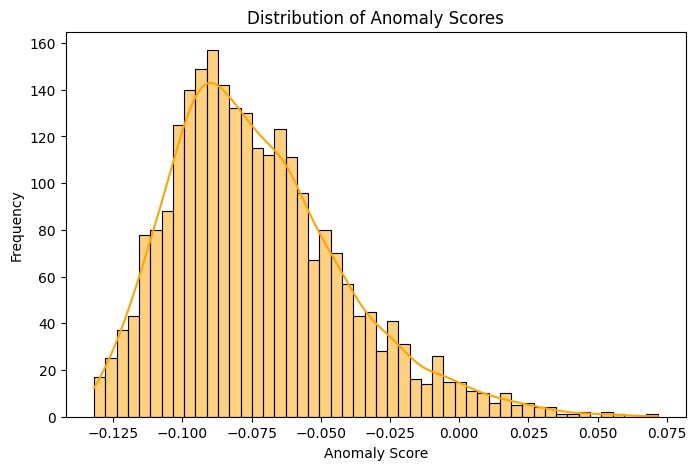

,AccountID,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,...,unique_devices_per_account,unique_ips_per_account,unique_accounts_per_devices,merchant_avg_amount,merchant_amount_deviation,avg_loginAttempts,loginAttemps_excess,TransactionAmount_log,AnomalyFlag,AnomalyScore
6,AC00199,7.08,Credit,Seattle,D000241,140.212.253.222,M019,ATM,37,Doctor,...,1,1,4,210.081333,-203.001333,1.000000,0.000000,2.089392,1,0.013508
85,AC00098,1340.19,Credit,Austin,D000574,165.114.224.47,M012,Online,54,Engineer,...,5,5,7,409.340952,930.849048,1.000000,0.000000,7.201313,1,0.014703
101,AC00018,98.54,Credit,El Paso,D000528,34.125.226.63,M095,Online,20,Student,...,3,3,3,205.840000,-107.300000,2.333333,-1.333333,4.600560,1,0.017546
147,AC00161,514.95,Debit,New York,D000109,23.92.205.75,M056,Online,41,Doctor,...,4,4,3,283.394091,231.555909,2.000000,3.000000,6.246010,1,0.016954
176,AC00363,1362.55,Debit,El Paso,D000213,93.52.44.101,M001,ATM,29,Engineer,...,12,12,3,260.002500,1102.547500,1.000000,0.000000,7.217847,1,0.053738
195,AC00363,3.30,Credit,Los Angeles,D000215,116.44.12.250,M085,Branch,50,Doctor,...,12,12,6,326.409600,-323.109600,1.000000,0.000000,1.458615,1,0.001197
274,AC00454,1176.28,Credit,Kansas City,D000476,50.202.8.53,M074,ATM,54,Engineer,...,4,4,4,330.619259,845.660741,2.000000,3.000000,7.070962,1,0.071646
340,AC00107,1830.00,Debit,San Antonio,D000436,62.27.235.199,M082,Online,55,Engineer,...,5,4,4,365.976111,1464.023889,1.000000,0.000000,7.512618,1,0.025515
375,AC00316,1392.54,Debit,El Paso,D000113,63.67.150.226,M013,Branch,41,Doctor,...,6,6,5,315.646970,1076.893030,1.500000,-0.500000,7.239603,1,0.025907
394,AC00326,6.30,Debit,Columbus,D000539,210.160.90.52,M017,Branch,80,Retired,...,5,5,4,272.020870,-265.720870,1.800000,3.200000,1.987874,1,0.025118


✅ Isolation Forest model saved successfully.


In [6]:

# -------------------------
# 2. Initialize Isolation Forest
# -------------------------
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.03,        # expected fraction of anomalies (tune this)
    max_samples='auto',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# -------------------------
# 3. Train the model
# -------------------------
iso_forest.fit(x)

# -------------------------
# 4. Get predictions and anomaly scores
# -------------------------
# predictions: -1 = anomaly, 1 = normal
preds = iso_forest.predict(x)
scores = iso_forest.decision_function(x)  # higher score = more normal

# Convert to readable form
df['AnomalyFlag'] = np.where(preds == -1, 1, 0)  # 1 = anomaly/fraud
df['AnomalyScore'] = -scores  # invert so higher means more anomalous

# -------------------------
# 5. Analyze results
# -------------------------
print("Anomalies detected:", df['AnomalyFlag'].sum(), "out of", len(df))

# Distribution of scores
plt.figure(figsize=(8,5))
sns.histplot(df['AnomalyScore'], bins=50, kde=True, color='orange')
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()

# Quick overview of anomaly transactions
display(df[df['AnomalyFlag'] == 1].head(10))

# -------------------------
# 6. Save model artifact
# -------------------------
joblib.dump(iso_forest, "../artifacts/isolation_forest_model.joblib")
print("✅ Isolation Forest model saved successfully.")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [13]:
import json
with open('../artifacts/feature_names.json') as file:
    feature_names = json.load(file)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [9]:
feature_names = [col for col in df.columns]
x_features = df[feature_names]

In [10]:
x_features

,AccountID,TransactionAmount,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,...,unique_devices_per_account,unique_ips_per_account,unique_accounts_per_devices,merchant_avg_amount,merchant_amount_deviation,avg_loginAttempts,loginAttemps_excess,TransactionAmount_log,AnomalyFlag,AnomalyScore
0,AC00128,14.09,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,...,7,7,6,298.023438,-283.933438,1.000,0.000,2.714032,0,-0.076044
1,AC00455,376.24,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,...,6,7,5,295.009259,81.230741,1.000,0.000,5.932882,0,-0.099879
2,AC00019,126.29,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,...,4,4,5,350.868000,-224.578000,1.000,0.000,4.846468,0,-0.097833
3,AC00070,184.50,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,...,8,8,6,290.427097,-105.927097,1.375,-0.375,5.223055,0,-0.091969
4,AC00411,13.45,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,...,6,6,3,287.662903,-274.212903,1.000,0.000,2.670694,0,-0.073514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,AC00297,856.21,Credit,Colorado Springs,D000625,21.157.41.17,M072,Branch,33,Doctor,...,10,10,3,314.232000,541.978000,1.000,0.000,6.753683,0,-0.011227
2508,AC00322,251.54,Debit,Tucson,D000410,49.174.157.140,M029,Branch,48,Doctor,...,9,9,5,271.292800,-19.752800,1.000,0.000,5.531570,0,-0.087207
2509,AC00095,28.63,Debit,San Diego,D000095,58.1.27.124,M087,Branch,56,Retired,...,8,8,5,227.976400,-199.346400,1.000,0.000,3.388787,0,-0.093135
2510,AC00118,185.97,Debit,Denver,D000634,21.190.11.223,M041,Online,23,Student,...,4,4,2,258.365500,-72.395500,1.000,0.000,5.230948,0,-0.079631
